In [ ]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/NeuralNetwork'
pict_results_path = os.environ['PACKAGE_OUTPUT']+'/NeuralNetwork/picts'
files_results_path = os.environ['PACKAGE_OUTPUT']+'/NeuralNetwork/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+
                                  'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 0.000111818313599 seconds
Time to read data file: 1.59125208855 seconds


In [2]:
# Get data in correct format
from keras.utils import np_utils

# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)

all_data = all_data.transpose()

# turn targets in sparse mode
trgt_sparse = np_utils.to_categorical(all_trgt)

Using Theano backend.
/Users/natmourajr/.virtualenvs/kerasenv/lib/python2.7/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/Users/natmourajr/.virtualenvs/kerasenv/lib/python2.7/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


# Train process
## The train will modify one file and create three different files

### Log File:
This file will store basic information of all Package's trains and it will guide the analyses file to recognize which train information file should load. In each train this file should be appended with a new line contend the basic information to find the train information file (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis

### Train Information File
This file will store full information of the train performed (all parameters) in its name (each train information file will have a different name). And it will guide which train classifier file or which train result file should be open for analysis (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis

### Train Classifier File
This file will store the classifier after train, the folds information and the train evolution (when this exists) (NATIVE FORMAT) or (PYTHON FORMAT) - This file should not be access by all programs

### Train Result File
This file will store the classifier result for all data and classification target (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis


In [34]:
# Train Process
from Functions import LogFunctions as log
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from datetime import datetime  
from datetime import timedelta 

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry(package_name="Classification",analysis_name='NeuralNetwork')

# Create a train information file
n_folds = 10
n_inits = 1
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['norm'] = norm

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
classifiers_name = result_analysis_path+'/classifiers_files'+'/'+date+'_classifiers'

CVO = cross_validation.StratifiedKFold(all_trgt, train_info['n_folds'])
CVO = list(CVO)
train_info['CVO'] = CVO

# train classifiers
classifiers = {}
trn_desc = {}


# try to estimate time to be done...
total_trains = train_info['n_folds']*train_info['n_inits']
nn_trained = 0 

for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
       
    print 'Train Process for %i Fold of %i Folds'%(ifold,train_info['n_folds'] )
    
    best_init = 0
    best_loss = 999
    
    for i_init in range(train_info['n_inits']):
        #print 'Init: %i of %i'%(i_init,train_info['n_inits'])
        model = Sequential()
        model.add(Dense(30, input_dim=all_data.shape[1], init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
        model.add(Activation('tanh'))

        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd
                      ,metrics=['accuracy'])

        # Train model
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
        start_time = time.time()
        init_trn_desc = model.fit(norm_all_data[train_id], trgt_sparse[train_id], 
                                nb_epoch=50, 
                                batch_size=8,
                                callbacks=[earlyStopping], 
                                verbose=0,
                                validation_data=(all_data[test_id],trgt_sparse[test_id]),
                                shuffle=True)
        end_time = time.time()
        train_time = end_time -start_time
        nn_trained += 1
        
        now = datetime.now()
        finish_time  = now + timedelta(seconds = (total_trains-nn_trained)*train_time)
        
        print 'Estimated Finish Time: %s'%(
        finish_time.strftime("%Y/%m/%d-%H:%M:%S"))
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifiers[ifold] = model
            trn_desc[ifold] = init_trn_desc
            
classifiers_file = open(classifiers_name+'.pickle', "wb")
pickle.dump([classifiers,trn_desc],classifiers_file)
classifiers_file.close()
#joblib.dump([classifiers,trn_desc],classifiers_name+'.jbl',compress=9)
joblib.dump([train_info],train_info_name,compress=9)


Train Process for 0 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:21:11
Train Process for 1 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:19:46
Train Process for 2 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:25:48
Train Process for 3 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:21:23
Train Process for 4 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:28:59
Train Process for 5 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:30:04
Train Process for 6 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:26:31
Train Process for 7 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:28:50
Train Process for 8 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:29:47
Train Process for 9 Fold of 10 Folds
Estimated Finish Time: 2016/08/02-11:28:36


['/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/NeuralNetwork/train_info_files/2016_08_02_11_01_14_train_info.jbl']

In [3]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="Classification")
print log_entries

{0: {'date': '2016_08_01_20_46_33', 'package': 'NeuralNetwork'}, 1: {'date': '2016_08_01_20_46_58', 'package': 'NeuralNetwork'}, 2: {'date': '2016_08_01_20_50_50', 'package': 'NeuralNetwork'}, 3: {'date': '2016_08_01_20_56_28', 'package': 'NeuralNetwork'}, 4: {'date': '2016_08_01_20_57_01', 'package': 'NeuralNetwork'}, 5: {'date': '2016_08_01_21_09_08', 'package': 'NeuralNetwork'}, 6: {'date': '2016_08_01_21_17_07', 'package': 'NeuralNetwork'}, 7: {'date': '2016_08_01_21_18_48', 'package': 'NeuralNetwork'}, 8: {'date': '2016_08_01_21_20_42', 'package': 'NeuralNetwork'}, 9: {'date': '2016_08_01_22_28_23', 'package': 'NeuralNetwork'}, 10: {'date': '2016_08_01_22_42_00', 'package': 'NeuralNetwork'}, 11: {'date': '2016_08_02_10_28_22', 'package': 'NeuralNetwork'}, 12: {'date': '2016_08_02_11_01_14', 'package': 'NeuralNetwork'}}


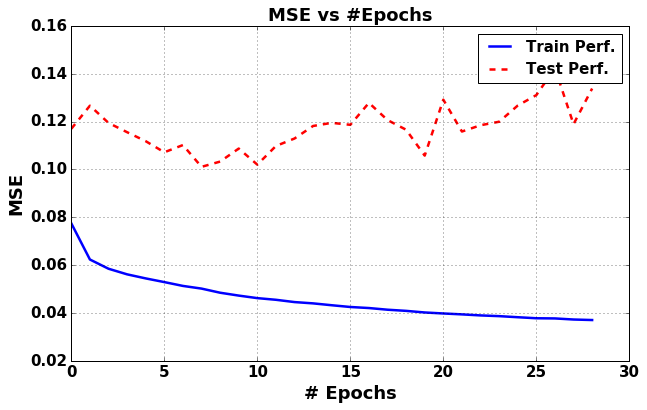

In [36]:
# plot train updates
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig1 = plt.figure(figsize=(10,6))

choose_date = '2016_08_02_11_01_14'

classifiers_name = result_analysis_path+'/classifiers_files'+'/'+date+'_classifiers'

classifiers_file = open(classifiers_name+'.pickle', "r")
[classifiers,trn_desc] = pickle.load(classifiers_file)
classifiers_file.close()

ifold = 0

l1 = plt.plot(trn_desc[ifold].epoch,
              trn_desc[ifold].history['loss'],color=[0,0,1],
              linewidth=2.5,linestyle='solid',label='Train Perf.')
l2 = plt.plot(trn_desc[ifold].epoch,
              trn_desc[ifold].history['val_loss'],color=[1,0,0],
              linewidth=2.5,linestyle='dashed',label='Test Perf.')
cost = ''
if model.loss == 'mean_squared_error':
    cost = 'MSE'

plt.grid(True)
plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
plt.ylabel(cost,fontsize=18,fontweight='bold')
plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
plt.legend()

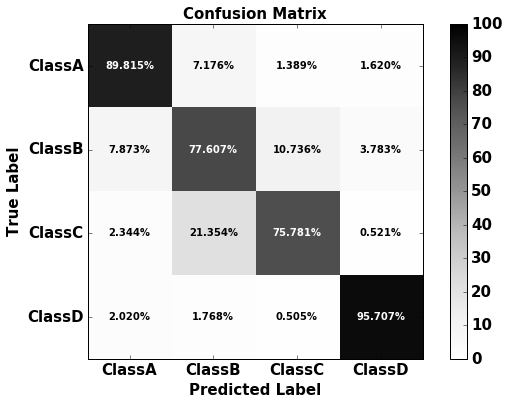

In [19]:
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

from sklearn.metrics import confusion_matrix

class_labels=["ClassA", "ClassB", "ClassC","ClassD"]

choose_date = '2016_08_02_11_01_14'
classifiers_name = result_analysis_path+'/classifiers_files'+'/'+choose_date+'_classifiers'
classifiers_file = open(classifiers_name+'.pickle', "r")
[classifiers,trn_desc] = pickle.load(classifiers_file)

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)

train_info = train_info[0]

ifold = 1
train_id, test_id = train_info['CVO'][ifold]
    
# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)

output = classifiers[ifold].predict(norm_all_data)
all_output = np.argmax(output,axis=1)
#confusion_matrix(trgt_sparse, output, labels=["ClassA", "ClassB", "ClassC","ClassD"])
cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(class_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(class_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(class_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)

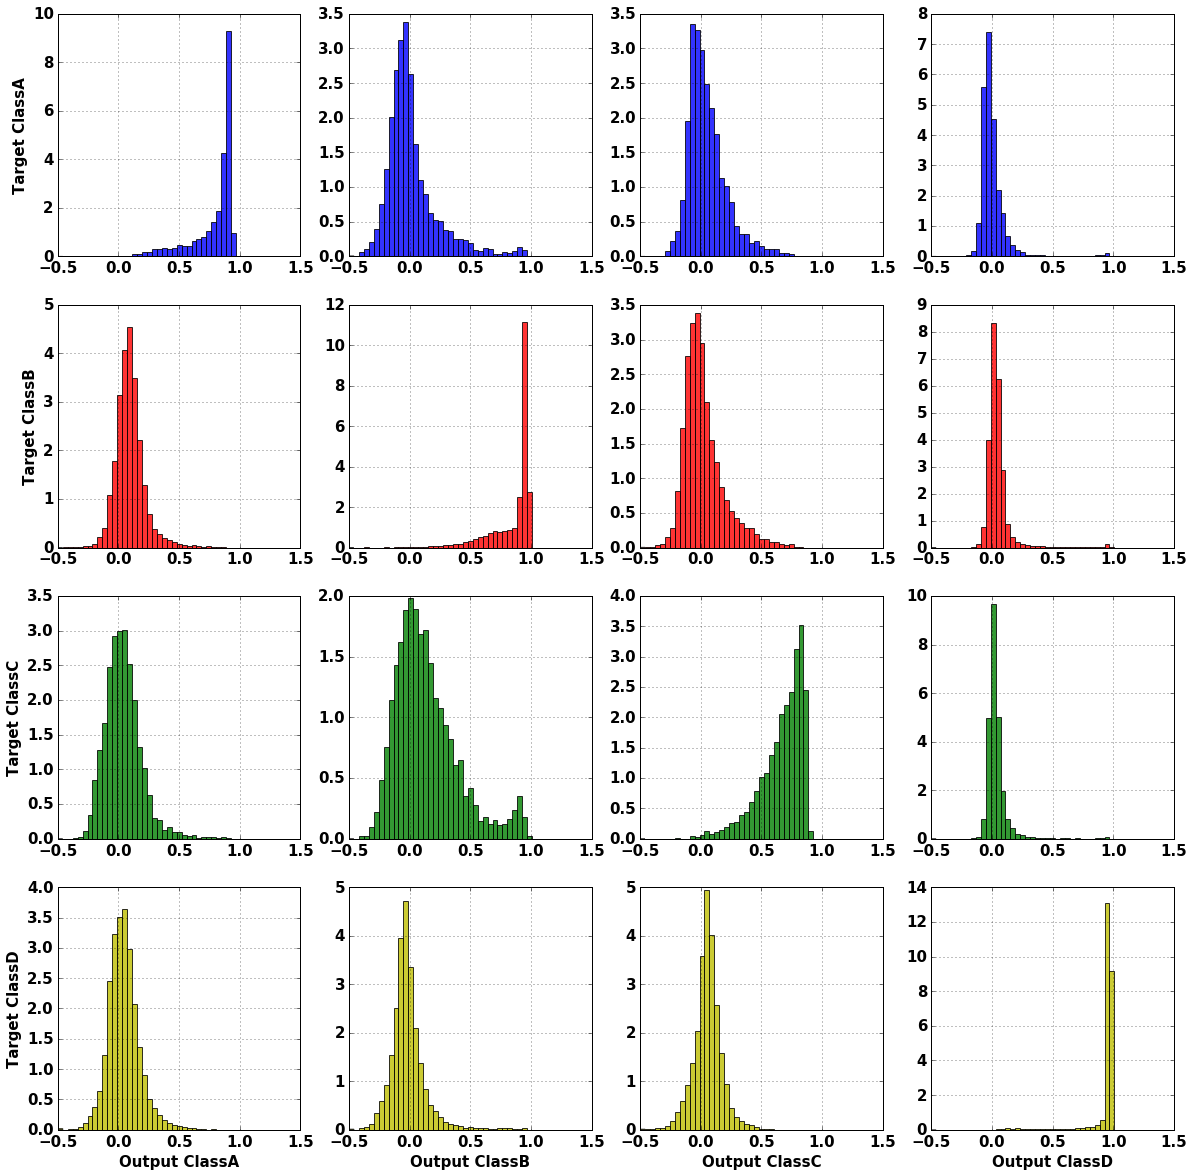

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)


class_labels=["ClassA", "ClassB", "ClassC","ClassD"]

choose_date = '2016_08_02_11_01_14'
classifiers_name = result_analysis_path+'/classifiers_files'+'/'+choose_date+'_classifiers'
classifiers_file = open(classifiers_name+'.pickle', "r")
[classifiers,trn_desc] = pickle.load(classifiers_file)

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)

train_info = train_info[0]

ifold = 1
train_id, test_id = train_info['CVO'][ifold]
    
# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)

output = classifiers[ifold].predict(norm_all_data)

from sklearn.neighbors import KernelDensity

m_bins = np.linspace(-0.5, 1.5, 50)

m_colors = ['b', 'r', 'g', 'y']

kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'
for i_target in range(trgt_sparse.shape[1]):
    for i_output in range(output.shape[1]):
        subplot_id = output.shape[1]*i_target+i_output
        m_pts = output[all_trgt==i_target,i_output]
        
        n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                      fc=m_colors[i_target],
                                                      alpha=0.8, normed=1)
        
        if i_output == 0:
            ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                             fontweight='bold',fontsize=15)
        if i_target == 3:
            ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                             fontweight='bold',fontsize=15)
        ax[i_target,i_output].grid()
        

In [63]:
np.sum(n)

7918.0

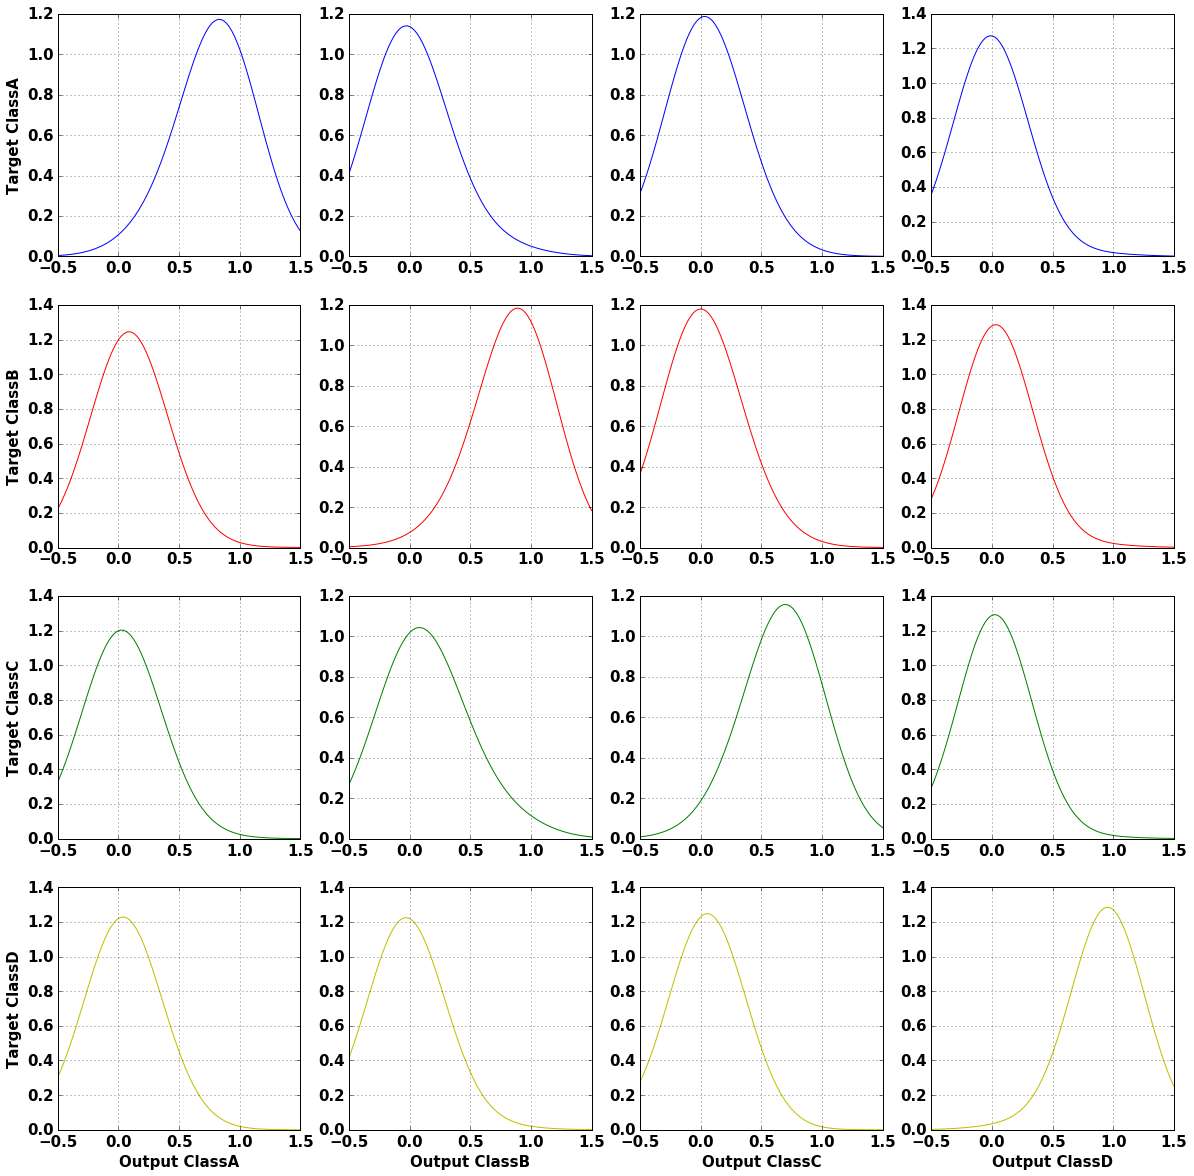

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)


class_labels=["ClassA", "ClassB", "ClassC","ClassD"]

choose_date = '2016_08_02_11_01_14'
classifiers_name = result_analysis_path+'/classifiers_files'+'/'+choose_date+'_classifiers'
classifiers_file = open(classifiers_name+'.pickle', "r")
[classifiers,trn_desc] = pickle.load(classifiers_file)

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)

train_info = train_info[0]

ifold = 1
train_id, test_id = train_info['CVO'][ifold]
    
# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)

output = classifiers[ifold].predict(norm_all_data)

from sklearn.neighbors import KernelDensity

m_bins = np.linspace(-0.5, 1.5,100)

m_colors = ['b', 'r', 'g', 'y']

kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'
for i_target in range(trgt_sparse.shape[1]):
    for i_output in range(output.shape[1]):
        subplot_id = output.shape[1]*i_target+i_output
        m_pts = output[all_trgt==i_target,i_output]
        
        kde = KernelDensity(kernel=kernel,algorithm='auto',
                            bandwidth=0.3).fit(m_pts[:, np.newaxis])
        log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
        ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                   color=m_colors[i_target])
        if i_output == 0:
            ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                             fontweight='bold',fontsize=15)
        if i_target == 3:
            ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                             fontweight='bold',fontsize=15)
        ax[i_target,i_output].grid()
        